# BETA BANK

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.
Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

1.- Crea un modelo con el máximo valor F1 posible. 

2.- Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba.

3.- Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

## REVISAMOS DATOS.

In [45]:
#Importamos las librerias que necesitaremos.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [46]:
# Mostramos el DataFrame
data = pd.read_csv('/datasets/Churn.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [47]:
# Revisamos que los tipos de las columnas sean los correctos.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [48]:
# Cambiamos los nombres de las columnas a minusculas y cambiams el formato.
data.columns = data.columns.str.lower()
data.rename(columns={'rownumber' : 'row_number',
                    'customerid' : 'customer_id',
                    'creditscore' : 'credit_score',
                    'numofproducts' : 'num_of_products',
                    'hascrcard' : 'has_cr_card',
                    'isactivemember': 'is_active_member',
                    'estimatedsalary' : 'estimated_salary'}, inplace =True
                    )

In [49]:
# Mostramos los cambios.
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [50]:
data['surname'].value_counts()

Smith       32
Martin      29
Scott       29
Walker      28
Brown       26
            ..
Severson     1
Lovely       1
Currey       1
Nicoll       1
Joslin       1
Name: surname, Length: 2932, dtype: int64

En el DataFrame tenemos columnas que no nos aportan valor para realizar nuestros modelos como son row_number, customer_id y surname, el primero es el numero de columna, el segundo un numero de cliente y el tercero su apellido al revisar esta ultima columna no encontramos nada que se considere extraño como que exista una cantidad inusual de personas con el mismo apellido por lo que eliminaremos estas columnas y seguiremos con el analisis.

In [51]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis =1)
data

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [52]:
# Buscamos valores nulos.
data.isna().sum()

credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

Los valores nulos de la columna tenure se llenaran con la media del agrupamieto de gender, geography y tenure para poder realizar nuestro analisis.

In [53]:
tenure_median = data.groupby(['gender', 'geography'])['tenure'].transform('median')
print(tenure_median.head())

0    5.0
1    5.0
2    5.0
3    5.0
4    5.0
Name: tenure, dtype: float64


In [54]:
# Llenamos valores nulos con cero
data['tenure'] = data['tenure'].fillna(tenure_median)
data

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [55]:
# Buscamos valores duplicados.
data.duplicated().sum()

0

In [56]:
# Revisamos nuestra columna target
data['exited']. value_counts()

0    7963
1    2037
Name: exited, dtype: int64

### CONCLUSION.

Despues de revisar el DataFrame y hacer las correcciones necesarias en los nombres de las columnas, llenado de valores nulos y eliminar columnas analizando nuestra columna target tenemos un desequilibrio de clases de 80 20 por el momento correremos modelos de Logistic Regression, Decission Tree y Random Forest y analisaremos los resultados, en cada caso se realizara la codificacion necesaria para el modelo de Logistic Regression se hara la codificacion One Hot y en el caso del Decission Tree y Random Forest la codificacion de etiquetas y se dividiran los datos en conjuntos de entrenamiento y prueba.

## MODELOS CON DESEQUILIBRIO DE CLASES.

### LOGISTIC REGRESSION.

In [57]:
# Dividimos los conjuntos de entrenamiento y validacion.

data_ohe = pd.get_dummies(data, drop_first=True)
features_ohe = data_ohe.drop(['exited'], axis=1)
target_ohe = data_ohe['exited']

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
features_ohe, target_ohe, test_size = 0.25, random_state=12345)

In [58]:
# Entrenamos modelo de regresion logistica.
model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(features_train_ohe, target_train_ohe)
predicted_valid_ohe = model.predict(features_valid_ohe)

accuracy = accuracy_score(target_valid_ohe, predicted_valid_ohe)
print("Accuracy: ", accuracy)
print()
print(confusion_matrix(target_valid_ohe, predicted_valid_ohe))
print()
print('recall: ', recall_score(target_valid_ohe, predicted_valid_ohe))
print()
print('precision', precision_score(target_valid_ohe, predicted_valid_ohe))
print()
f1_logistic_desq = f1_score(target_valid_ohe, predicted_valid_ohe)
print('f1: ', f1_logistic_desq)
print()

probabilities_valid = model.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid_ohe, probabilities_one_valid)
print('auc_roc',auc)

Accuracy:  0.7828

[[1921   44]
 [ 499   36]]

recall:  0.06728971962616823

precision 0.45

f1:  0.11707317073170732

auc_roc 0.6760847542270101


Tenemos un valor muy bajo en f1 por lo que este modelo en con estos datos nos es completamente inservible.

### DECISION TREE.

In [59]:
# Dividimos conjuntos de entrenamiento y validacion.

encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)
features_or = data_ordinal.drop(['exited'], axis=1)
target_or = data_ordinal['exited']

features_train_or, features_valid_or, target_train_or, target_valid_or = train_test_split(
features_or, target_or, test_size = 0.25, random_state=12345)

In [60]:
# Entrenamos modelo Decision Tree.

best_depth=0
best_score=0

for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345)
    model.fit(features_train_or, target_train_or)
    predict_valid_or = model.predict(features_valid_or)
    
    score = model.score(features_valid_or, target_valid_or)
    
    if score > best_score:
        best_score = score
        best_depth = depth
        
print('max_depth = {}, score = {}'.format(best_depth, best_score))

best_score = 0
best_depth = 0

max_depth = 7, score = 0.8528


In [61]:
# Resultados de las metricas.
model = DecisionTreeClassifier(max_depth = 7, random_state = 12345)
model.fit(features_train_or, target_train_or)
predicted_valid_or = model.predict(features_valid_or)

accuracy = accuracy_score(target_valid_or, predicted_valid_or)
print("Accuracy: ", accuracy)
print()
print(confusion_matrix(target_valid_or, predicted_valid_or))
print()
print('recall: ', recall_score(target_valid_or, predicted_valid_or))
print()
print('precision', precision_score(target_valid_or, predicted_valid_or))
print()
f1_tree_desq = f1_score(target_valid_or, predicted_valid_or)
print('f1: ', f1_tree_desq)
print()

probabilities_valid = model.predict_proba(features_valid_or)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid_or, probabilities_one_valid)
print('auc_roc',auc)

Accuracy:  0.8528

[[1911   54]
 [ 314  221]]

recall:  0.4130841121495327

precision 0.8036363636363636

f1:  0.5456790123456791

auc_roc 0.828774583244156


Los resultados mejoraron con respecto al modelo anterior pero sigue estando por debajo de lo que necesitamos.

### RANDOM FOREST.

In [62]:
# Entrenamos modelo random forest.
best_score=0
best_est =0
best_depth = 0

for est in range(1, 41, 10):
    for depth in range(1,21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train_or, target_train_or)
        score = model.score(features_valid_or, target_valid_or)
    
        if score > best_score:
            best_score = score
            best_est = est
            best_depth = depth
    
print('Accuracy del mejor modelo de validacion (score= {}, n_estimators= {}, depth= {}'.format(best_score, best_est, best_depth))

Accuracy del mejor modelo de validacion (score= 0.8556, n_estimators= 31, depth= 13


In [63]:
# Resultados de las metricas.
model = RandomForestClassifier(random_state=12345, n_estimators=31, max_depth=13)
model.fit(features_train_or, target_train_or)
predicted_valid_or = model.predict(features_valid_or)

accuracy = accuracy_score(target_valid_or, predicted_valid_or)
print("Accuracy: ", accuracy)
print()
print(confusion_matrix(target_valid_or, predicted_valid_or))
print()
print('recall: ', recall_score(target_valid_or, predicted_valid_or))
print()
print('precision', precision_score(target_valid_or, predicted_valid_or))
print()
f1_forest_desq = f1_score(target_valid_or, predicted_valid_or)
print('f1: ', f1_forest_desq)
print()

probabilities_valid = model.predict_proba(features_valid_or)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid_or, probabilities_one_valid)
print('auc_roc',auc)

Accuracy:  0.8556

[[1906   59]
 [ 302  233]]

recall:  0.4355140186915888

precision 0.797945205479452

f1:  0.5634824667472794

auc_roc 0.8534351145038168


Aqui tenemos los mejores valores comparado con los modelos anteriores pero aun falta mejorar para llegar al valor f1 que nos piden.

### CONCLUSION.

Despues de realiar las validaciones con los tres modelos vemos que ninguno nos da un valor f1 mayor al que nos solicitan, en el caso de la Regresion Logistica tenemos los peores resultados en todas las metricas y en el caso de Decision tree y Random Forest los valores se elevan incluso tenemos resultados de precision de .82 pero el valor f1 es de .54, ademas podemos ver como el valor auc en todos los casos es mucho mayor que el f1 como en el caso de la regresion logistica don de el valor f1 es de .11 y el auc es de .67, por lo que se realizara las pruebas en los modelos con los enfoques de ajuste de pesos, subajuste y sobreajuste y se analizaran los resultados.

## AJUSTE DE PESOS.

### LOGISTIC REGRESSION.

In [64]:
# Modelo Regresion Logistica con ajuste de pesos.
model = LogisticRegression(random_state=12345, solver = 'liblinear', class_weight = 'balanced')
model.fit(features_train_ohe, target_train_ohe)
predicted_valid_ohe = model.predict(features_valid_ohe)

accuracy = accuracy_score(target_valid_ohe, predicted_valid_ohe)
print("Accuracy: ", accuracy)
print()
print(confusion_matrix(target_valid_ohe, predicted_valid_ohe))
print()
print('recall: ', recall_score(target_valid_ohe, predicted_valid_ohe))
print()
print('precision', precision_score(target_valid_ohe, predicted_valid_ohe))
print()
f1_logistic_ajuste = f1_score(target_valid_ohe, predicted_valid_ohe)
print('f1: ', f1_logistic_ajuste)
print()

probabilities_valid = model.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid_ohe, probabilities_one_valid)
print('auc_roc',auc)

Accuracy:  0.686

[[1336  629]
 [ 156  379]]

recall:  0.708411214953271

precision 0.3759920634920635

f1:  0.491250810110175

auc_roc 0.7563691707688284


Vemos una mejora significativa con el modelo con desequilibrio de clases.

### DECISION TREE

In [65]:
# modelo decision tree con ajuste de pesos
best_depth=0
best_score=0

for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345, class_weight='balanced')
    model.fit(features_train_or, target_train_or)
    predict_valid_or = model.predict(features_valid_or)
    
    score = model.score(features_valid_or, target_valid_or)
    
    if score > best_score:
        best_score = score
        best_depth = depth
        
print('max_depth = {}, score = {}'.format(best_depth, best_score))

best_score = 0
best_depth = 0

max_depth = 5, score = 0.8024


In [66]:
model = DecisionTreeClassifier(max_depth = 5, random_state = 12345, class_weight='balanced')
model.fit(features_train_or, target_train_or)
predicted_valid_or = model.predict(features_valid_or)

accuracy = accuracy_score(target_valid_or, predicted_valid_or)
print("Accuracy: ", accuracy)
print()
print(confusion_matrix(target_valid_or, predicted_valid_or))
print()
print('recall: ', recall_score(target_valid_or, predicted_valid_or))
print()
print('precision', precision_score(target_valid_or, predicted_valid_or))
print()
f1_tree_ajuste = f1_score(target_valid_or, predicted_valid_or)
print('f1: ', f1_tree_ajuste)
print()

probabilities_valid = model.predict_proba(features_valid_or)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid_or, probabilities_one_valid)
print('auc_roc',auc)

Accuracy:  0.8024

[[1633  332]
 [ 162  373]]

recall:  0.697196261682243

precision 0.5290780141843971

f1:  0.6016129032258064

auc_roc 0.8414125704501676


En este caso tambien mejoro el modelo un poco comparado con los datos desequilibrados pero no llega al valor f1 que necesitamos.

### RANDOM FOREST

In [67]:
# Modelo random forest con ajuste de pesos
best_score=0
best_est =0
best_depth = 0

for est in range(1, 41, 10):
    for depth in range(1,21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train_or, target_train_or)
        score = model.score(features_valid_or, target_valid_or)
    
        if score > best_score:
            best_score = score
            best_est = est
            best_depth = depth
    
print('Accuracy del mejor modelo de validacion (score= {}, n_estimators= {}, depth= {}'.format(best_score, best_est, best_depth))

Accuracy del mejor modelo de validacion (score= 0.8556, n_estimators= 31, depth= 13


In [68]:
model = RandomForestClassifier(random_state=12345, n_estimators=31, max_depth=13, class_weight='balanced')
model.fit(features_train_or, target_train_or)
predicted_valid_or = model.predict(features_valid_or)

accuracy = accuracy_score(target_valid_or, predicted_valid_or)
print("Accuracy: ", accuracy)
print()
print(confusion_matrix(target_valid_or, predicted_valid_or))
print()
print('recall: ', recall_score(target_valid_or, predicted_valid_or))
print()
print('precision', precision_score(target_valid_or, predicted_valid_or))
print()
f1_forest_ajuste = f1_score(target_valid_or, predicted_valid_or)
print('f1: ', f1_forest_ajuste)
print()

probabilities_valid = model.predict_proba(features_valid_or)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid_or, probabilities_one_valid)
print('auc_roc',auc)

Accuracy:  0.8516

[[1844  121]
 [ 250  285]]

recall:  0.5327102803738317

precision 0.7019704433497537

f1:  0.6057385759829967

auc_roc 0.8486785094290268


Tambien vemos una mejora en el modelo e incluso hemos llegado al valor f1 que nos solicitan.

### CONCLUSION.

El ajuste de pesos ayudo a mejorar el resultado de las metricas en general incluyendo a f1 y auc, en el caso de la regresion logistica don de el f1 era de .11 subio a .49 con el balance de clases y en el caso de random forest ya estamos sobre el resultado que se nos solicita que era de .59 y obtuvimos .60, sin embargo se realiaran las pruebas de suajuste y sobreajuste para ver cuanto podemos mejorar los modelos.

## SUBMUESTREO

En el caso de submuestreo y sobremuestreo ya no incluiremos la metrica accuracy y dejaremos solo las otras que manejamos ademas de incluir la grafica del auc_roc y tendremos ahora conjuntos de entrenamiento, validacion y prueba para que al final tomemos el modelo con los mejores resultados y hagamos una prueba final.

In [89]:
# Creamos variables cada una con las cantidades de cada clase en la columna exited y dos nuevos Dataframes 
#con los valores de cada clase.
count_class_0, count_class_1 = data.exited.value_counts()
data_class_0 = data[data['exited'] == 0]
data_class_1 = data[data['exited'] == 1]

print(data_class_0.shape)
print(data_class_1.shape)

(7963, 11)
(2037, 11)


In [90]:
# Creamos un dataframe uniendo los dos anteriores que creamos.
data_class_0_under = data_class_0.sample(count_class_1) #Tomamos una muestra de valores de clase 0 con el mismo numero de la clase 1.

data_test_under = pd.concat([data_class_0_under, data_class_1], axis=0)

print(data_test_under.exited.value_counts())

0    2037
1    2037
Name: exited, dtype: int64


In [91]:
# Mostramos nuevo DataFrame.
data_test_under

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
3242,411,France,Female,36,10.0,0.00,1,0,0,120694.35,0
2433,759,Spain,Female,74,6.0,128917.84,1,1,1,48244.64,0
6027,850,Germany,Male,44,3.0,140393.65,2,0,1,186285.52,0
264,738,Spain,Male,31,5.0,79019.80,1,1,1,18606.23,0
6825,529,Spain,Female,44,1.0,0.00,2,0,0,14161.30,0
...,...,...,...,...,...,...,...,...,...,...,...
9981,498,Germany,Male,42,3.0,152039.70,1,1,1,53445.17,1
9982,655,Germany,Female,46,7.0,137145.12,1,1,0,115146.40,1
9991,597,France,Female,53,4.0,88381.21,1,1,0,69384.71,1
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


### LOGISTIC REGRESSION

[[258 143]
 [135 279]]

recall 0.6739130434782609

precision 0.6611374407582938

f1 0.6674641148325359

auc_roc 0.712283301408315


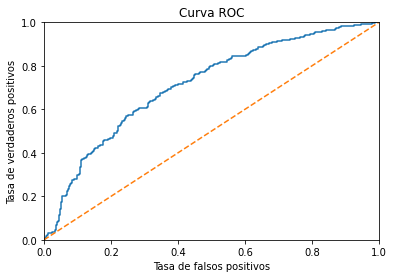

In [72]:
# Modelo logistic regression subajustado
data_ohe = pd.get_dummies(data_test_under, drop_first=True)
features = data_ohe.drop(['exited'], axis=1)
target = data_ohe['exited']

features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size = 0.20, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
features_train, target_train, test_size = 0.25, random_state=12345)

model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid))
print()
print('recall', recall_score(target_valid, predicted_valid))
print()
print('precision', precision_score(target_valid, predicted_valid))
print()
f1_logistic_submuestreo = f1_score(target_valid, predicted_valid)
print('f1', f1_logistic_submuestreo)
print()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

Vemos que con datos equilibrados en caso de submuestreo tambien con el modelo de regresion logistica que nos daba los peores resultados ya tambien en este momento sobrepasamos el valor f1 que necesitamos.

### DECISION TREE

In [73]:
# Modelo Desicion tree subajustado
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_test_under), columns=data.columns)
features = data_ordinal.drop(['exited'], axis=1)
target = data_ordinal['exited']

features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size = 0.20, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
features_train, target_train, test_size = 0.25, random_state=12345)

best_depth=0
best_score=0

for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345)
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    
    score = model.score(features_valid, target_valid)
    
    if score > best_score:
        best_score = score
        best_depth = depth
        
print('max_depth = {}, score = {}'.format(best_depth, best_score))

best_score = 0
best_depth = 0

max_depth = 6, score = 0.7717791411042945


[[1212  388]
 [ 399 1186]]

recall 0.7482649842271294

precision 0.7534942820838628

f1 0.7508705286483064

auc_roc 0.8417874605678235


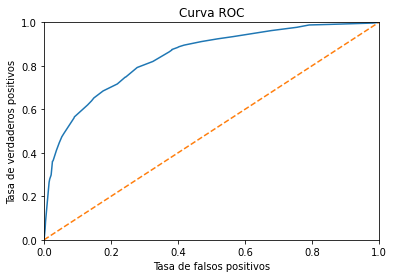

In [92]:
model = DecisionTreeClassifier(max_depth = 6, random_state = 12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid))
print()
print('recall', recall_score(target_valid, predicted_valid))
print()
print('precision', precision_score(target_valid, predicted_valid))
print()
f1_tree_submuestreo = f1_score(target_valid, predicted_valid)
print('f1', f1_tree_submuestreo)
print()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

Este modelo tambien supero el valor f1 de .59 y vemos que con el submmuestreo los modelos y todas las metricas aumentan comparado con hacer un ajuste de pesos.

### RANDOM FOREST

In [75]:
# Modelo random forest subajustado
for est in range(1, 41, 10):
    for depth in range(1,21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        score = model.score(features_valid, target_valid)
    
        if score > best_score:
            best_score = score
            best_est = est
            best_depth = depth
    
print('Accuracy del mejor modelo de validacion (score= {}, n_estimators= {}, depth= {}'.format(best_score, best_est, best_depth))

Accuracy del mejor modelo de validacion (score= 0.7901840490797546, n_estimators= 11, depth= 17


[[1399  201]
 [  82 1503]]

recall 0.9482649842271293

precision 0.8820422535211268

f1 0.9139556096077835

auc_roc 0.9719505126182962


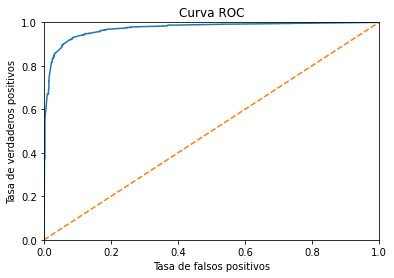

In [93]:
model = RandomForestClassifier(random_state=12345, n_estimators=11, max_depth=17)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid))
print()
print('recall', recall_score(target_valid, predicted_valid))
print()
print('precision', precision_score(target_valid, predicted_valid))
print()
f1_forest_submuestreo = f1_score(target_valid, predicted_valid)
print('f1', f1_forest_submuestreo)
print()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

Nuevamente en el modelo random forest tenemos los mejores resultados en todos los resultados de las etricas y sobrepasamos por mucho el valor f1 necesario.

### CONCLUSION.

Al hacer un submuestreo equilibrando las clases los resultados en general en todos los modelos mejoraron bastante y todos nuestros modelos superaron el valor f1 que nos piden siendo nuevamente el random forest el que enrega los mejores resultados.

## SOBREMUESTREO

In [94]:
# Realizamos los mismos pasos que en el submuestreo creando dos variables y dos dataframes.
count_class_0, count_class_1 = data.exited.value_counts()
data_class_0 = data[data['exited'] == 0]
data_class_1 = data[data['exited'] == 1]

print(data_class_0.shape)
print(data_class_1.shape)

(7963, 11)
(2037, 11)


In [95]:
# Unimos nuestros dataframes que acabamos de crear para tener uno con mas muestras de la clase 1 y que este equilibrado.
data_class_1_over = data_class_1.sample(count_class_0, replace =True)

data_test_over = pd.concat([data_class_0, data_class_1_over], axis=0)

data_test_over.exited.value_counts()

0    7963
1    7963
Name: exited, dtype: int64

In [96]:
data_test_over

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
...,...,...,...,...,...,...,...,...,...,...,...
1534,573,Germany,Female,47,4.0,152522.47,1,0,1,164038.07,1
5535,648,Germany,Female,32,8.0,157138.99,3,1,0,190994.48,1
5087,740,Spain,Male,43,9.0,0.00,1,1,0,199290.68,1
2813,758,France,Female,52,7.0,125095.94,1,1,0,171189.83,1


### LOGISTIC REGRESSION

[[1084  516]
 [ 502 1083]]

recall 0.6832807570977918

precision 0.6772983114446529

f1 0.6802763819095478

auc_roc 0.7302354100946372


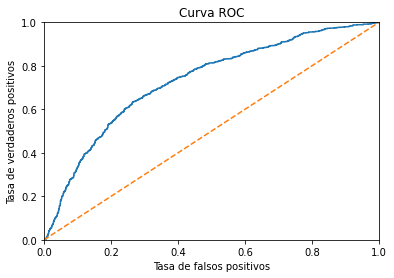

In [80]:
# Modelo logistic regression sobreajustado
data_ohe = pd.get_dummies(data_test_over, drop_first=True)
features = data_ohe.drop(['exited'], axis=1)
target = data_ohe['exited']

features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size = 0.20, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
features_train, target_train, test_size = 0.25, random_state=12345)

model = LogisticRegression(random_state=12345, solver = 'liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid))
print()
print('recall', recall_score(target_valid, predicted_valid))
print()
print('precision', precision_score(target_valid, predicted_valid))
print()
f1_logistic_sobremuestreo = f1_score(target_valid, predicted_valid)
print('f1', f1_logistic_sobremuestreo)
print()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

Vemos una ligera mejora en el valor f1 en comparacion con el submuestreo pero ya no es tan significativa.

### DECISION TREE

In [81]:
# Modelo decision tree sobreajustado
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_test_over), columns=data.columns)
features = data_ordinal.drop(['exited'], axis=1)
target = data_ordinal['exited']

features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size = 0.20, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
features_train, target_train, test_size = 0.25, random_state=12345)

best_depth=0
best_score=0

for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345)
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    
    score = model.score(features_valid, target_valid)
    
    if score > best_score:
        best_score = score
        best_depth = depth
        
print('max_depth = {}, score = {}'.format(best_depth, best_score))

best_score = 0
best_depth = 0

max_depth = 20, score = 0.8891679748822606


[[1314  286]
 [  67 1518]]

recall 0.9577287066246056

precision 0.8414634146341463

f1 0.8958394806727648

auc_roc 0.8882569006309148


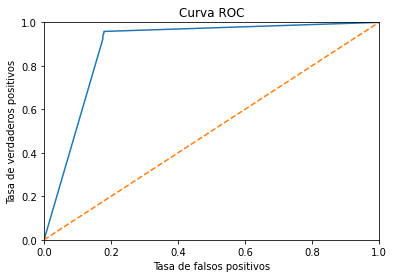

In [97]:
model = DecisionTreeClassifier(max_depth = 20, random_state = 12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid))
print()
print('recall', recall_score(target_valid, predicted_valid))
print()
print('precision', precision_score(target_valid, predicted_valid))
print()
f1_tree_sobremuestreo = f1_score(target_valid, predicted_valid)
print('f1', f1_tree_sobremuestreo)
print()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

En el caso de este modelo si vemos una mejora significativa en relacion con el submuestreo en todos los valores en el caso de la metrica f1 es una mejora de .12.

### RANDOM FOREST

In [83]:
# Modelo random forest sobreajustado
for est in range(1, 41, 10):
    for depth in range(1,21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        score = model.score(features_valid, target_valid)
    
        if score > best_score:
            best_score = score
            best_est = est
            best_depth = depth
    
print('Accuracy del mejor modelo de validacion (score= {}, n_estimators= {}, depth= {}'.format(best_score, best_est, best_depth))

Accuracy del mejor modelo de validacion (score= 0.926530612244898, n_estimators= 31, depth= 19


[[1428  172]
 [  62 1523]]

recall 0.9608832807570978

precision 0.8985250737463126

f1 0.9286585365853659

auc_roc 0.978875788643533


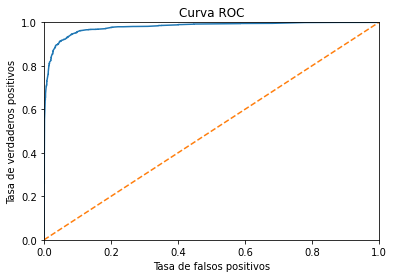

In [98]:
model = RandomForestClassifier(random_state=12345, n_estimators=31, max_depth=19)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(confusion_matrix(target_valid, predicted_valid))
print()
print('recall', recall_score(target_valid, predicted_valid))
print()
print('precision', precision_score(target_valid, predicted_valid))
print()
f1_forest_sobremuestreo = f1_score(target_valid, predicted_valid)
print('f1', f1_forest_sobremuestreo)
print()

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

Nuevamente el random forest nos da los mejores resultados tambien en el sobremuestreo mejorando en .15 el valor f1 comparado con el submuestreo y todos los resultados de nuestras metricas estan poor encima del .90.

### CONCLUSION.

En el sobremuestreo tenemos mejores resultados en general con todos los modelos en todas mlas metricas por lo que tomaremos ahora el modelo de bosque aleatorio y realizaremos una prueba final y con el conjunto de prueba sobreajustado y mostraremos tambien los resultados de las metricas.

## PRUEBA FINAL.

[[1345  160]
 [  65 1616]]

recall 0.9613325401546698

precision 0.9099099099099099

f1 0.9349146658952848

auc_roc 0.9792632529679969


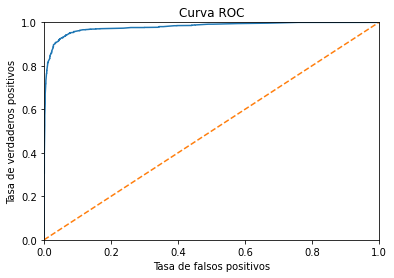

In [99]:
model = RandomForestClassifier(random_state=12345, n_estimators=31, max_depth=19)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)

print(confusion_matrix(target_test, predicted_valid))
print()
print('recall', recall_score(target_test, predicted_valid))
print()
print('precision', precision_score(target_test, predicted_valid))
print()
f1_final = f1_score(target_test, predicted_valid)
print('f1', f1_final)
print()

probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:,1]

auc = roc_auc_score(target_test, probabilities_one_valid)
print('auc_roc', auc)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.show()

Los resultados no mejoraron mucho con respecto a los realizados con el conjunto de validacion pero si mejoraron.

In [100]:
datos = [['Logistic Regression', f1_logistic_desq, f1_logistic_ajuste, f1_logistic_submuestreo, f1_logistic_sobremuestreo],
         ['Decision Tree', f1_tree_desq, f1_tree_ajuste, f1_tree_submuestreo, f1_tree_sobremuestreo],
         ['Random Forest', f1_forest_desq, f1_forest_ajuste, f1_forest_submuestreo, f1_forest_sobremuestreo],
         ['Random Forest Final Test', '', '', '' , f1_final]]
columnas = ['model', 'imbalance', 'class_weight', 'sub_sampling', 'over_sampling']
f1_table = pd.DataFrame(datos, columns = columnas)
f1_table.style.set_properties(**{'text-align': 'left'})
f1_table

,model,imbalance,class_weight,sub_sampling,over_sampling
0,Logistic Regression,0.117073,0.491251,0.667464,0.680276
1,Decision Tree,0.545679,0.601613,0.750871,0.895839
2,Random Forest,0.563482,0.605739,0.913956,0.928659
3,Random Forest Final Test,,,,0.934915


## CONCLUSION GENERAL

1.- En la tabla anterior vemos como el desequilibrio de clases afecta mucho el funcionamiento de los modelos siendo inservibles y necesitando forzosamente ser mejorados con las tecnicas diseñadas para el desequilibrio.

2.- Tomando el hiperparametro de peso de clase como balanceado los resultados mejoran en algunos casos bastante como con el modelo de regresion logistica pero aun son bajos los resultados de las metricas aunque en el caso del decision tree y random forest incluso superamos el valor f1 que nos pedian pero seguia siendo bajo.

3.- El submuestreo dio mejores resultados aun y ahora todos los modelos tenian valores en sus metricas mucho mejores y todos pasaban el valor f1 de .59, incluso el modelo random forest casi llego al valor que tendria en su mejor desempeño con el sobremuestreo.

4.- El sobremuestreo dio los mejores resultados de todas las pruebas y el random forest nos dio los mejores resultados de todos los modelos con todas las metricas por encima del .90 por lo que podemos decir que mientras mas datos tengamos y estos se encuentren en equibrados los modelos aprendertan mejor y podran hacer mejores predicciones, sin embargo para tener una vision realista de los alcances de nuestro modelo y sus resultados necesitariamos probarlo con un dataframe completamente nuevo que se encuentre equilibrado desde un inicio ya que lo que hacemos es que artificialmente duplicamos los registros para crear un nuevo dataframe y eso puede hacer que los resultados se vean mejor de los que realmente pueden ser.